## Spike Challenge -Predicción de precios de insumos básicos en Chile

In [349]:
# Cargamos las librerías que usaremos en el desafío
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

### 1.- Datos: Precipitaciones, Indicadores Económicos Banco Central

In [175]:
# Cargamos los datos
precipitaciones_crudo = pd.read_csv('precipitaciones.csv')
economia_crudo = pd.read_csv('banco_central.csv')

### 2.- Análisis de datos. Creación de variable

#### Precipitaciones
Para el análisis de datos, comenzaremos observando los datos de precipitaciones.

In [176]:
precipitaciones_crudo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   date                                 496 non-null    object 
 1   Coquimbo                             496 non-null    float64
 2   Valparaiso                           496 non-null    float64
 3   Metropolitana_de_Santiago            496 non-null    float64
 4   Libertador_Gral__Bernardo_O_Higgins  496 non-null    float64
 5   Maule                                496 non-null    float64
 6   Biobio                               496 non-null    float64
 7   La_Araucania                         496 non-null    float64
 8   Los_Rios                             496 non-null    float64
dtypes: float64(8), object(1)
memory usage: 35.0+ KB


Podemos observar que esta tabla contiene información de prepitaciones entre las regiones entre Coquimbo y Los Ríos, donde cada columna contiene los datos de precipitación de cada región. La tabla contiene 496 filas y ninguna columna contiene valores nulos. Es notable la ausencia de datos para la región de Los Lagos, la cual es un importante centro productor de leche. Registraremos los nombres de las columnas correspondientes a las precipitaciones para futuras referencias y revisaremos las primeras cinco filas.


In [177]:
# Registramos los nombres de las columnas correspondientes a regiones
cols_region = precipitaciones_crudo.columns[1:]

In [178]:
precipitaciones_crudo.head()

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
0,1989-02-01,0.719033,0.117045,0.028272,0.0,0.724667,9.172945,22.595834,52.268010
1,1998-10-01,0.065216,0.000000,0.011493,0.0,0.008968,2.089674,14.702087,45.142041
2,2001-02-01,2.030026,0.047987,0.002634,0.0,0.032163,10.768351,29.465057,65.571098
3,2008-11-01,0.622784,0.000000,0.015872,0.0,1.734168,25.083557,64.901645,113.093488
4,2009-04-01,0.008065,0.000000,0.009396,0.0,12.080715,56.233424,96.364235,155.622235


Vemos que los datos de precipitaciones están en magnitudes acorde a la unidad de medida correspondiente (mm).

Los datos no están ordenadas cronológicamente, así que los reordenaremos. Además, cambiaremos el tipo de datos en que están contenidas las fechas.

In [179]:
# Mantendremos una copia de los datos originales
precipitaciones = precipitaciones_crudo.sort_values(by='date').copy()

# Convertimos la columna "date" a un formato "de fechas"
try:
    precipitaciones['Fecha'] = precipitaciones['date'].apply(
        lambda s: pd.to_datetime(s[0:10],format='%Y-%m-%d')
        )
except ValueError:
    print('Existe una fecha no valida!')
    
precipitaciones = precipitaciones.drop('date', axis=1)

Revisaremos ahora si alguna fecha está duplicada:

In [180]:
precipitaciones['Fecha'].nunique()

496

La cantidad de valores únicos de fechas es igual a la cantidad de filas de la columna, por lo que no existen valores duplicados.

Revisaremos ahora una descripción de los datos de precipitaciones:

In [181]:
precipitaciones.describe()

,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
count,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,16.154691,32.450980,49.666682,72.249805,98.662773,128.113406,151.486456,199.451789
std,32.629286,55.434330,74.361099,101.426112,122.766771,130.056094,126.628503,140.073615
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.001170,0.005331,0.748127
25%,0.821521,1.538162,5.297546,5.343992,11.897363,29.356684,52.930343,89.805643
50%,4.071036,9.037825,19.087592,25.995969,45.649888,79.558557,110.570990,159.467940
75%,16.137600,38.409213,63.408364,101.875093,142.230716,184.751307,208.316243,274.594590
max,347.133889,441.048604,524.592667,645.515752,759.177712,702.434707,661.211203,717.735673


De forma esperable, la media de lluvia caída aumenta mientras más al sur se encuentre una región. La variabilidad también aumenta en la misma dirección.

#### Datos económicos

Continuaremos ahora con la revisión de los datos económicos:

In [182]:
economia_crudo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 85 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   Periodo                                                                             614 non-null    object 
 1   Imacec_empalmado                                                                    300 non-null    object 
 2   Imacec_produccion_de_bienes                                                         300 non-null    object 
 3   Imacec_minero                                                                       300 non-null    object 
 4   Imacec_industria                                                                    301 non-null    object 
 5   Imacec_resto_de_bienes                                                              300 non-null   

A diferencia de la tabla de precipitaciones, esta tabla presenta sólo 7 columnas en formato numérico, mientras que las demás están en un formato que no facilita su análisis. Sólo las columnas relacionadas con precios de ciertos commodities y la cantidad de autos nuevos vendidos están correctamente formateadas. Es notable también la gran cantidad de valores ausentes (nulos) en cada columna.

Es interesante el hecho de que, basandose en el nombre y la cantidad de datos nulos/no-nulos que presentan cada variable, es posible hacer una clasificación de ellas. Nuevamente, registraremos los nombres de las columnas de acuerdo a su categoría, para futuras referencias.

In [183]:
cols_Imacec = [col for col in economia_crudo.columns if 'Imacec' in col]
cols_PIB = [col for col in economia_crudo.columns if 'PIB' in col]
cols_Ocupacion = [col for col in economia_crudo.columns if 'Ocupa' in col]
cols_Ocupacion.append('No_sabe__No_responde_Miles_de_personas')
cols_precios = [col for col in economia.columns if 'Precio' in col]

Revisaremos las primeras y últimas cinco filas.

In [184]:
# Primeras cinco filas
economia_crudo.head()

,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
0,2013-03-01 00:00:00 UTC,102.796.218,10.546.824,978.554.365,102.297.537,114.994.919,110.729.395,100.064.328,103.163.651,103.405.852,...,865.903.468,102.761.705,98.915.705,NaN,108.387.837,580.480.672,NaN,NaN,NaN,28577.0
1,2013-04-01 00:00:00 UTC,101.664.842,999.272.757,927.333.293,104.485.589,102.199.311,106.098.291,102.600.107,101.937.319,102.766.884,...,867.806.065,968.087.179,914.276.663,NaN,104.545.429,544.815.032,NaN,NaN,NaN,32206.0
2,2013-05-01 00:00:00 UTC,101.642.954,993.959.922,96.133.164,105.445.361,968.789.055,100.462.117,104.083.216,101.953.299,102.322.796,...,878.030.947,978.471.874,966.913.278,NaN,99.468.801,56.891.916,NaN,NaN,NaN,31589.0
3,2013-06-01 00:00:00 UTC,998.310.201,968.367.884,102.400.933,999.212.106,89.190.493,939.504.414,103.857.161,100.222.381,995.139.235,...,913.180.348,966.647.135,981.820.974,NaN,94.969.678,56.594.867,NaN,NaN,NaN,28457.0
4,2013-07-01 00:00:00 UTC,964.696.194,961.051.418,980.029.022,100.882.112,901.785.886,92.776.599,969.309.272,962.069.134,962.804.305,...,909.263.447,100.100.749,990.198.382,NaN,102.128.977,586.329.899,NaN,NaN,NaN,31736.0


In [185]:
# Últimas cinco filas
economia_crudo.tail()

,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
609,2008-08-01 00:00:00 UTC,792.872.358,809.540.557,844.433.727,862.655.599,721.027.743,640.625.573,829.163.596,799.073.886,786.659.097,...,99.298.129,NaN,847.665.895,NaN,905.764.363,475.746.478,NaN,NaN,NaN,NaN
610,2008-09-01 00:00:00 UTC,786.802.278,814.228.983,875.931.483,85.990.071,693.602.068,629.581.947,810.645.789,791.396.405,772.867.447,...,972.530.264,NaN,859.131.907,NaN,894.789.858,453.055.435,NaN,NaN,NaN,NaN
611,2008-10-01 00:00:00 UTC,841.834.519,896.565.998,980.164.017,889.145.021,79.386.738,653.517.611,856.040.952,85.038.187,818.131.883,...,105.609.319,NaN,902.538.952,NaN,981.854.401,478.309.081,NaN,NaN,NaN,NaN
612,2008-11-01 00:00:00 UTC,82.846.325,845.666.687,864.252.442,83.063.253,843.834.773,638.884.202,881.094.389,838.436.575,825.672.572,...,10.738.286,NaN,877.968.927,NaN,914.543.986,466.174.958,NaN,NaN,NaN,NaN
613,2008-12-01 00:00:00 UTC,881.247.458,983.189.901,10.705.794,888.736.894,955.925.017,810.432.344,820.841.346,887.995.505,847.322.725,...,107.490.006,NaN,959.869.013,NaN,934.298.114,487.878.953,NaN,NaN,NaN,NaN


Vemos que la mayoría de los datos están en un formato XXX.XXX.XXX, pese a que aparentemente sean datos que varíen tanto en sus unidades de medida como en sus ordenes de magnitud.

Si bien menos importante, también vemos que las fechas no están ordenadas cronológicamente. Nuevamente, cambiaremos el formato de la columna 'Periodo'.

In [186]:
economia = economia_crudo.copy();
try:
    economia['Periodo'] = economia['Periodo'].apply(
        lambda s: pd.to_datetime(s[0:10],format='%Y-%m-%d')
        )
except ValueError:
    print('Existe una fecha no valida!')

Existe una fecha no valida!


In [187]:
# Nuevo intento, pero ahora sabemos que hay una fecha no valida
economia['Periodo_corregido'] = economia['Periodo'].apply(lambda s: s[0:10])

Buscaremos las fechas anómalas, comenzando por revisar los años correspondientes a cada período:

In [188]:
economia['Periodo_corregido'].apply(lambda s: s[0:4]).value_counts()

2019    13
2018    13
1975    12
1998    12
2002    12
1993    12
1996    12
1999    12
2014    12
1994    12
2000    12
1988    12
2008    12
2012    12
2007    12
1989    12
1983    12
2003    12
1977    12
1978    12
1980    12
1970    12
2009    12
1986    12
1992    12
2020    12
1987    12
2013    12
2006    12
1979    12
1997    12
1985    12
1981    12
2001    12
2004    12
1995    12
2010    12
1982    12
1991    12
1976    12
1984    12
2011    12
2005    12
1971    12
2015    12
2016    12
1974    12
2017    12
1972    12
1973    12
1990    12
Name: Periodo_corregido, dtype: int64

In [189]:
print(economia['Periodo_corregido'].apply(lambda s: int(s[0:4])).min())
print(economia['Periodo_corregido'].apply(lambda s: int(s[0:4])).max())

1970
2020


Nos muestra que todos los años presentan 12 períodos, excepto 2019, que presenta 13. Sin embargo, todos los años caen dentro del rango 1970-2020.

Probaremos buscando en los meses:

In [190]:
economia['Periodo_corregido'].apply(lambda s: s[5:7]).value_counts()

08    53
06    51
02    51
03    51
01    51
10    51
04    51
07    51
11    51
09    51
05    51
12    50
13     1
Name: Periodo_corregido, dtype: int64

¡Existe un mes 13! Eliminaremos la anomalía y haremos un nuevo intento de cambiar el formato de la columna 'Periodo'.

In [191]:
mes_anomalo = economia['Periodo_corregido'].apply(lambda p: int(p[5:7]) > 12)
economia = economia[~(mes_anomalo)]

In [192]:
# Creamos una nueva columna 'Periodo'
economia = economia.drop('Periodo_corregido',axis=1)
try:
    economia['Periodo'] = economia['Periodo'].apply(
        lambda s: pd.to_datetime(s[0:10],format='%Y-%m-%d')
        )
except ValueError:
    print('Existe una fecha no valida!')

In [193]:
# Ordenamos los datos cronológicamente
economia.sort_values(by='Periodo', inplace=True)

Ahora, hay que corregir los datos numéricos. Comenzaremos dando un nuevo formato a los datos de las columnas `'Imacec*'`, basándonos en datos del Banco Central: [1](https://si3.bcentral.cl/Siete/ES/Siete/Cuadro/CAP_CCNN/MN_CCNN76/CCNN2013_IMACEC_01 'Datos IMACEC') Aparentemente, los valores oscilan entre 90 y 110 (o poco más) unidades arbitrarias, donde "100" corresponde al IMACEC promedio de 2013.

Revisaremos para qué años se tienen datos:

In [194]:
# Crearemos una función que revise los años para los que tenemos datos
def revision_anios(columnas):
    for col in columnas:
        data_valida = economia[col].notnull()
        anios = economia['Periodo'][data_valida].dt.year.unique()
        print(f"{col}:\n {anios}")

In [195]:
revision_anios(cols_Imacec)

Imacec_empalmado:
 [1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
Imacec_produccion_de_bienes:
 [1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
Imacec_minero:
 [1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
Imacec_industria:
 [1972 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
Imacec_resto_de_bienes:
 [1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
Imacec_comercio:
 [1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
Imacec_servicios:
 [1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011

Todas las columnas presentan datos entre 1996 y 2020. A partir de la
referencia [1](https://si3.bcentral.cl/Siete/ES/Siete/Cuadro/CAP_CCNN/MN_CCNN76/CCNN2013_IMACEC_01 'Datos IMACEC'), se encuentra que efectivamente el rango de valores está entre 40-120 aprox. Por lo tanto, usaremos como "regla ad-hoc" que:
 - Si el valor inicial es un 1, entonces es del orden de 1e2
 - Si es distinto de 1, entonces es del orden de 1e1.

In [196]:
def valor_imacec_corregido(valor_anomalo):
    valor_anomalo = str(valor_anomalo).replace('.','')
    digitos = len(valor_anomalo)
    if valor_anomalo[0] == '1':
        pre_valor = float(valor_anomalo)
        valor = pre_valor/np.power(10,digitos-3)
    elif valor_anomalo[0] in '23456789':
        pre_valor = float(valor_anomalo)
        valor = pre_valor/np.power(10,digitos-2)
    else:
        valor = np.nan

    return valor

In [197]:
# Corregimos las columnas
for col in cols_Imacec:
    nueva_col = economia[col].apply(valor_imacec_corregido).copy()
    economia = economia.drop(col,axis=1)
    economia[col] = nueva_col

Corregiremos los valores de las columnas `'PIB-*'`, usando la información de la referencia [2](https://si3.bcentral.cl/Siete/ES/Siete/Cuadro/CAP_CCNN/MN_CCNN76/CCNN2013_P1/CCNN2013_P1 'Datos PIB').

In [198]:
# Observamos para qué años se tienen datos
revision_anios(cols_PIB)

PIB_Agropecuario_silvicola:
 [1974 2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Pesca:
 [2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Mineria:
 [2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Mineria_del_cobre:
 [2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Otras_actividades_mineras:
 [2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Industria_Manufacturera:
 [1972 2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Alimentos:
 [2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Bebidas_y_tabaco:
 [2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Textil:
 [2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Maderas_y_muebles:
 [2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Celulosa:
 [2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Refinacion_de_petroleo:
 [2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Quimica:
 [1971 1972 1973 2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Minerales_no_metalicos_y_metalica_basica:
 [2010 2013 2014 2015 2016 2017 2018 2019 2020]
PIB_Productos_metalicos:
 [2013 2014 2015 2016 2017 2018 201

Vemos que se tienen datos para todas las columnas entre los años 2013 y 2020, excepto `"PIB_Minerales_no_metalicos_y_metalica_basica"` que posee datos de 2010 y algunas columnas que incluyen datos del período entre 1971-1974:
- PIB_Agropecuario_silvicola (1974)
- PIB_Industria_Manufacturera:(1972)
- PIB_Quimica (1971-1973)

Revisaremos los datos anteriores a 2013.

In [199]:
pre75 = economia['Periodo'] < '1975-01-01'
economia['PIB_Agropecuario_silvicola'][pre75]

146    NaN
147    NaN
148    NaN
149    NaN
150    NaN
151    NaN
152    NaN
153    NaN
154    NaN
155    NaN
156    NaN
157    NaN
158    NaN
159    NaN
160    NaN
161    NaN
162    NaN
163    NaN
164    NaN
165    NaN
166    NaN
167    NaN
168    NaN
169    NaN
170    NaN
171    NaN
172    NaN
173    NaN
174    NaN
175    NaN
176    NaN
177    NaN
178    NaN
179    NaN
180    NaN
181    NaN
182    NaN
183    NaN
184    NaN
185    NaN
186    NaN
187    NaN
188    NaN
189    NaN
190    NaN
191    NaN
192    NaN
193    NaN
194    NaN
195    NaN
196    NaN
197    NaN
198    NaN
199    NaN
200    NaN
201    NaN
202    NaN
203      a
204    NaN
205    NaN
Name: PIB_Agropecuario_silvicola, dtype: object

Se observan que todos menos un dato son valores nulos. La excepción es un dato anómalo. Como probablemente la situcación se repita, buscaremos sólo los valores no nulos de las demás columnas en el período anterior a 1975.

In [200]:
print(economia['PIB_Industria_Manufacturera'][
    pre75 & economia['PIB_Industria_Manufacturera'].notnull()])
print(economia['PIB_Quimica'][pre75 & economia['PIB_Quimica'].notnull()])
print(economia['PIB_Minerales_no_metalicos_y_metalica_basica'][
    economia['Periodo'].dt.year == 2010])

174    a
175    a
176    a
177    a
Name: PIB_Industria_Manufacturera, dtype: object
162    a
176    a
182    a
Name: PIB_Quimica, dtype: object
107    NaN
108      a
109    NaN
110    NaN
111    NaN
112    NaN
113    NaN
114    NaN
115    NaN
116    NaN
117    NaN
118    NaN
Name: PIB_Minerales_no_metalicos_y_metalica_basica, dtype: object


Efectivamente, son valores anómalos que deben ser limpiados.

A partir de la referencia [2](https://si3.bcentral.cl/Siete/ES/Siete/Cuadro/CAP_CCNN/MN_CCNN76/CCNN2013_P1/CCNN2013_P1 'Datos PIB'), vemos que el orden de magnitud de los valores de cada columna varía. Además, para aplicar la misma regla "ad-hoc" que se hizo en IMACEC hay que tener el cuidado de si un valor que comienza con "1" es del mismo orden de magnitud o es 10 veces mayor que los valores que empiezan con otro dígito. Es por eso que creamos dos funciones diferenciadas para cada caso, donde el criterio para elegir uno u otro caso es si entre los primeros dígitos está incluido el "9" o no.

In [201]:
# Diccionario con los órdenes de magnitud de los valores de PIB
ordenes_PIB = {
    'PIB_Agropecuario_silvicola': 3,
    'PIB_Pesca': 2,
    'PIB_Mineria': 3,
    'PIB_Mineria_del_cobre': 3,
    'PIB_Otras_actividades_mineras': 2,
    'PIB_Industria_Manufacturera': 3,
    'PIB_Alimentos': 3,
    'PIB_Bebidas_y_tabaco': 2,
    'PIB_Textil': 1,
    'PIB_Maderas_y_muebles': 2,
    'PIB_Celulosa': 2,
    'PIB_Refinacion_de_petroleo': 2,
    'PIB_Quimica': 2,
    'PIB_Minerales_no_metalicos_y_metalica_basica': 2,
    'PIB_Productos_metalicos': 2,
    'PIB_Electricidad': 2,
    'PIB_Construccion': 3,
    'PIB_Comercio': 3,
    'PIB_Restaurantes_y_hoteles': 2,
    'PIB_Transporte': 3,
    'PIB_Comunicaciones': 2,
    'PIB_Servicios_financieros': 3,
    'PIB_Servicios_empresariales': 3,
    'PIB_Servicios_de_vivienda': 3,
    'PIB_Servicios_personales': 3,
    'PIB_Administracion_publica': 3,
    'PIB_a_costo_de_factores': 5,
    'PIB': 5
}

# Revisa el digito inicial de cada valor de PIB
def digito_inicial_PIB(valor_anomalo):
    valor_anomalo = str(valor_anomalo).replace('.','')
    digitos = len(valor_anomalo)
    if valor_anomalo[0] in '123456789':
        valor = int(valor_anomalo[0])
    else:
        valor = np.nan

    return valor

# Corrige valores cuando todos son del mismo orden de magnitud
def valor_PIB_corregido(valor_anomalo,orden):
    valor_anomalo = str(valor_anomalo).replace('.','')
    digitos = len(valor_anomalo)
    if valor_anomalo[0] in '123456789':
        pre_valor = float(valor_anomalo)
        if digitos > orden+1:
            valor = pre_valor/np.power(10,digitos-(orden+1))
        else:
            valor = pre_valor*np.power(10,-digitos+orden+1)
    else:
        valor = np.nan

    return valor

# Corrige valores cuando algunos son un orden de magnitud mayor
def valor_PIB_corregido_varios_ordenes(valor_anomalo,orden):
    valor_anomalo = str(valor_anomalo).replace('.','')
    digitos = len(valor_anomalo)
    if valor_anomalo[0] == '1':
        pre_valor = float(valor_anomalo)
        if digitos > orden+2:
            valor = pre_valor/np.power(10,digitos-(orden+2))
        else:
            valor = pre_valor*np.power(10,-digitos+orden+2)
    elif valor_anomalo[0] in '23456789':
        pre_valor = float(valor_anomalo)
        if digitos > orden+1:
            valor = pre_valor/np.power(10,digitos-(orden+1))
        else:
            valor = pre_valor*np.power(10,-digitos+orden+1)
    else:
        valor = np.nan

    return valor

In [202]:
# Corregimos los valores de PIB

# Creamos diccionario de funciones para cada columna
fun_corrector_PIB = {}
for col in cols_PIB:
    digitos = economia[col].apply(digito_inicial_PIB).unique()
    if (1 in digitos) and (9 in digitos):
        def aux_valor_PIB(pib):
            return valor_PIB_corregido_varios_ordenes(pib,ordenes_PIB[col])
    else:
        def aux_valor_PIB(pib):
            return valor_PIB_corregido(pib,ordenes_PIB[col])
    fun_corrector_PIB[col] = aux_valor_PIB

# Corrección de valores
for col in cols_PIB:
    nueva_col = economia[col].apply(fun_corrector_PIB[col]).copy()
    economia = economia.drop(col,axis=1)
    economia[col] = nueva_col.values

Ahora corregiremos los valores de los precios de los _commodities_ , de forma similar a lo hecho anteriormente, a partir de la referencia [3](https://si3.bcentral.cl/siete/ES/Siete/Canasta?idCanasta=FHLES3325 'Datos Precios').

In [203]:
# Algunas columnas si están bien formateadas, así que seleccionamos
# las problemáticas
cols_precios_sin_formato = [c for c in economia.columns 
                            if ('Precio' in c) and (economia[c].dtype == 'object')]

In [204]:
# Observamos para qué años se tienen datos
revision_anios(cols_precios_sin_formato)

Precio_de_la_gasolina_en_EEUU_dolaresm3:
 [1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020]
Precio_del_cobre_refinado_BML_dolareslibra:
 [1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020]
Precio_del_kerosene_dolaresm3:
 [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020]


Tenemos datos para `"Precio_de_la_gasolina_en_EEUU_dolaresm3"` entre los años 1971 y 2020, `"Precio_del_cobre_refinado_BML_dolareslibra"` entre los años 1970 y 2020, y para `"Precio_del_kerosene_dolaresm3"` entre 2000 y 2020. Un vistazo rápido a la referencia [3](https://si3.bcentral.cl/siete/ES/Siete/Canasta?idCanasta=FHLES3325 'Datos Precios') nos muestra que `"Precio_del_kerosene_dolaresm3"` son valores del orden de 1e2 para todo el rango de fechas, pero no ocurre lo mismo con los valores de las otras dos columnas, por lo que nuevamente crearemos solucions "ad-hoc"

In [205]:
# Corregimos el precio del kerosene
def valor_kerosene(valor_anomalo):
    valor_anomalo = str(valor_anomalo).replace('.','')
    digitos = len(valor_anomalo)
    if valor_anomalo[0] in '123456789':
        pre_valor = float(valor_anomalo)
        valor = pre_valor/np.power(10,digitos-3)
    else:
        valor = np.nan

    return valor

col = 'Precio_del_kerosene_dolaresm3'
nueva_col = economia[col].apply(valor_kerosene).copy()
economia = economia.drop(col,axis=1)
economia[col] = nueva_col

Para `"Precio_de_la_gasolina_en_EEUU_dolaresm3"`, se encuentra que entre Agosto de 1971 y Marzo de 1999, los valores oscilan entre 30 y 300: A partir de ahí, los valores son todos del orden de 1e2. Luego, podemos ejecutar un cambio de formato similar a lo hecho para los valores en las columnas de `'Imacec*'`, donde se asignaba la posición de la coma decimal en función del dígito inicial.Podemos observar, sin embargo, que los valores de la columna `"Precio_de_la_gasolina_en_EEUU_dolaresm3"` están bien formateados hasta Diciembre de 1999:


In [206]:
# Alias para el nombre de la columna: Muy largo
gasolina = 'Precio_de_la_gasolina_en_EEUU_dolaresm3'

validos_gasolina = economia[gasolina].notnull()
gasolina_y_fecha = economia[['Periodo',gasolina]][validos_gasolina]

gasolina_y_fecha.head(360).tail(60)

,Periodo,Precio_de_la_gasolina_en_EEUU_dolaresm3
465,1996-08-01,153.37
466,1996-09-01,155.96
467,1996-10-01,169.67
468,1996-11-01,174.74
469,1996-12-01,170.99
470,1997-01-01,176.99
471,1997-02-01,164.12
472,1997-03-01,162.3
473,1997-04-01,154.45
474,1997-05-01,160.69


In [207]:
# Seleccionamos valores con mal formato
gasolina_mal_formato = (economia['Periodo'] >= '2000-01-01')

In [208]:
# Creamos nuestra funcion correctora...
def valor_precio_gasolina(valor):
    if valor[0]:
        valor_anomalo = str(valor[1]).replace('.','')
        digitos = len(valor_anomalo)
        # No hay valores nulos en este caso
        pre_valor = float(valor_anomalo)
        nuevo_valor = pre_valor/np.power(10,digitos-3)
    else:
        if str(valor[1])[0] in '123456789':
            nuevo_valor = float(valor[1])
        else:
            nuevo_valor = np.nan
    
    return nuevo_valor

In [209]:
# ... y la aplicamos:
nueva_gasolina = pd.Series(
    [val for val in zip(gasolina_mal_formato,economia[gasolina])]
    ).apply(valor_precio_gasolina)
economia = economia.drop(gasolina,axis=1)
economia[gasolina] = nueva_gasolina.values

Revisando la referencia [3](https://si3.bcentral.cl/siete/ES/Siete/Canasta?idCanasta=FHLES3325 'Datos Precios'), vemos que `"Precio_del_cobre_refinado_BML_dolareslibra"` presenta valores del orden de 1e0 a partir de Diciembre de 2003, mientras que para el período anterior, los valores oscilan entre 0.4 a 1.6.

Podemos observar, que los valores de la columna `"Precio_del_cobre_refinado_BML_dolareslibra"` presentan dos formatos diferenciados: Uno hasta Diciembre de 1999 y otro desde Enero de 2000, y que esta vez no todos los datos del primer grupo están correctamente formateados.

In [210]:
cobre = 'Precio_del_cobre_refinado_BML_dolareslibra'
validos_cobre = economia[cobre].notnull()
cobre_y_fecha = economia[['Periodo',cobre]][validos_cobre]

cobre_y_fecha.head(390).tail(60)

,Periodo,Precio_del_cobre_refinado_BML_dolareslibra
476,1997-07-01,1.11
477,1997-08-01,01.02
478,1997-09-01,0.96
479,1997-10-01,0.93
480,1997-11-01,0.87
481,1997-12-01,0.8
482,1998-01-01,0.77
483,1998-02-01,755
484,1998-03-01,0.79
485,1998-04-01,0.82


In [211]:
# Creamos nuestra funcion correctora, similar a la usada con los precios de la
# gasolina...
def valor_precio_cobre(valor):
    
    if str(valor[1])[0] == '0':
        valor_anomalo = str(valor[1])[1:].replace('.','')
    else:
        valor_anomalo = str(valor[1]).replace('.','')
    
    digitos = len(valor_anomalo)

    if valor[0]:
        # No hay valores nulos en este caso
        pre_valor = float(valor_anomalo)
        nuevo_valor = pre_valor/np.power(10,digitos-1)
    else:
        if valor_anomalo[0] == '1':
            pre_valor = float(valor_anomalo)
            nuevo_valor = pre_valor/np.power(10,digitos-1)
        elif valor_anomalo[0] in '23456789':
            pre_valor = float(valor_anomalo)
            nuevo_valor = pre_valor/np.power(10,digitos)
        else:
            nuevo_valor = np.nan
    
    return nuevo_valor

In [212]:
# ... y la aplicamos:
cobre_sobre_1_USD = economia['Periodo'] >= '2003-12-01'

nuevo_cobre = pd.Series(
    [val for val in zip(cobre_sobre_1_USD,economia[cobre])]
    ).apply(valor_precio_cobre)
economia = economia.drop(cobre,axis=1)
economia[cobre] = nuevo_cobre.values

Revisamos si hay valores duplicados a partir de los valores de `'Periodo'`:

In [213]:
economia['Periodo'].nunique()

611

El número de valores unicos no coincide con la cantidad de filas. Revisamos si hay algún valor duplicado y lo eliminamos:

In [214]:
economia['Periodo'].value_counts()

2019-08-01    2
2018-08-01    2
2003-06-01    1
2012-08-01    1
2017-12-01    1
             ..
1984-01-01    1
1992-05-01    1
1972-08-01    1
2005-04-01    1
1970-01-01    1
Name: Periodo, Length: 611, dtype: int64

In [215]:
# Se repiten dos fechas dos veces
# 2019-08-01 00:00:00 UTC    2
# 2018-08-01 00:00:00 UTC    2

# Aparentemente, dichas filas estan duplicadas
print(economia[economia['Periodo']=="2019-08-01"])
print(economia[economia['Periodo']=="2018-08-01"])

      Periodo Impuesto_al_valor_agregado Derechos_de_Importacion  \
78 2019-08-01                107.485.012             541.399.162   
79 2019-08-01                107.485.012             541.399.162   

    Precio_de_la_onza_troy_de_oro_dolaresoz  \
78                                   1503.5   
79                                   1503.5   

    Precio_de_la_onza_troy_de_plata_dolaresoz  \
78                                    172.056   
79                                    172.056   

    Precio_del_diesel_centavos_de_dolargalon  \
78                                    178.74   
79                                    178.74   

    Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas  \
78                                             2.2262                      
79                                             2.2262                      

    Precio_del_petroleo_Brent_dolaresbarril  \
78                                    59.25   
79                                   

In [216]:
# Eliminamos los duplicados
economia.drop_duplicates(inplace=True)

### 3.- Visualización

Comenzaremos creando una función que permita graficar series históricas de precipitaciones para un rango de fechas determinado.

In [217]:
def plot_serie_tiempo_precipitacion(region,fecha_inicio,fecha_termino):

    if region in precipitaciones.columns[1:-1]:

        fecha_inicio = pd.to_datetime(fecha_inicio,format='%Y-%m-%d')
        fecha_termino = pd.to_datetime(fecha_termino,format='%Y-%m-%d')

        # Advertencias sobre fechas
        minFechas = precipitaciones['Fecha'].min()
        maxFechas = precipitaciones['Fecha'].max()
        if minFechas > fecha_inicio:
            print(f"Fecha de inicio se ha cambiado a {minFechas}")
        if maxFechas < fecha_termino:
            print(f"Fecha de termino se ha cambiado a {maxFechas}")
        
        # Seleccion de datos propiamente tal
        cond_Inicio = precipitaciones['Fecha'] >= fecha_inicio
        cond_Final = precipitaciones['Fecha'] <= fecha_termino
        fechas_validas = (cond_Inicio & cond_Final)
    
        col_datos = ['Fecha',region]
        Data = precipitaciones[col_datos][fechas_validas]
        if len(fechas_validas) > 0:
            h = sns.lineplot(x='Fecha', y=region, data=Data)
            plt.show()
        else:
            print("No hay registros para ese rango de fechas")
            
    else:
        print("Región no válida")
        print("Regiones válidas son:")
        for col in precipitaciones.columns[1:-1]:
            print(col)
    

Graficamos las precipitaciones para la Región Libertador General Bernardo O'Higgins y para la Región Metropolitana entre las fechas 2000-01-01 y 2020-01-01:

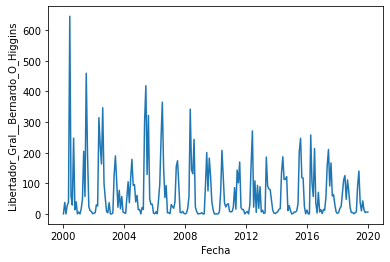

In [218]:
plot_serie_tiempo_precipitacion('Libertador_Gral__Bernardo_O_Higgins',
    '2000-01-01','2020-01-01')

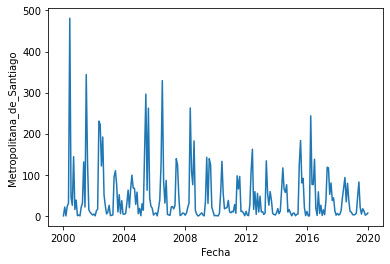

In [219]:
plot_serie_tiempo_precipitacion('Metropolitana_de_Santiago',
    '2000-01-01','2020-01-01')

Se observa en ambos gráficos que hay una estacionalidad muy marcada, habiendo una concentracion de lluvias en cierto período del año. Además, se observa como tendencia una disminución en la cantidad de agua caída dentro de dicho período con el paso de los años.

Ahora, crearemos una función que grafique múltiples series de tiempo mensuales de precipitaciones, donde cada serie de tiempo corresponda a un año, para una región determinada.

In [220]:
def plot_precipitaciones_mensuales(periodos_anuales,region):
    if region in precipitaciones[1:-1]:
        
        # Seleccion de datos propiamente tal
        def fecha_valida(yyyy):
            return yyyy in periodos_anuales
        data_periodo = \
            precipitaciones['Fecha'].dt.year.apply(fecha_valida)
        Data = precipitaciones[['Fecha',region]][data_periodo]
        Periodo = Data['Fecha'].dt.year
        Meses = Data['Fecha'].dt.month
        
        palette = sns.color_palette("tab10",len(periodos_anuales))
        if len(data_periodo) > 0:
            h = sns.lineplot(x=Meses, y=region, data=Data, hue=Periodo,
                palette=palette)
            h.set_xticks(range(1,13))
            x_ticks_labels = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago',
                'Sep','Oct','Nov','Dic']
            h.set_xticklabels(x_ticks_labels)
            plt.show()
        else:
            print("No hay registros para los años solicitados")
            
    else:
        print("Región no válida")
        print("Regiones válidas son:")
        for col in precipitaciones.columns[1:-1]:
            print(col)

Analizamos la situación del Maule durante los años 1982-2019:

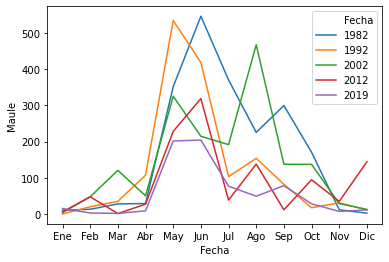

In [221]:
plot_precipitaciones_mensuales([1982, 1992, 2002, 2012, 2019],'Maule')

Se puede observar una disminución de las precipitaciones en Maule con el paso de los años, tanto en cantidad como en la duración de la época de lluvias.

En esta ocasión, graficaremos datos económicos. Crearemos una función que permita visualizar dos series históricas de PIB para un rango de fechas determinado.

In [222]:
def plot_dos_series_historicas_PIB(serie0,serie1,fecha_inicio=None,
    fecha_termino=None):

    if (serie0 in cols_PIB) and (serie1 in cols_PIB):

        if fecha_inicio:
            fecha_inicio = pd.to_datetime(fecha_inicio,format='%Y-%m-%d')
        if fecha_termino:
            fecha_termino = pd.to_datetime(fecha_termino,format='%Y-%m-%d')

        # Advertencias sobre fechas
        minFechas = economia['Periodo'].min()
        maxFechas = economia['Periodo'].max()
        if (fecha_inicio is None) or (minFechas > fecha_inicio):
            print(f"Fecha de inicio se ha cambiado a {minFechas}")
            fecha_inicio = minFechas
        if (fecha_termino is None) or (maxFechas < fecha_termino):
            print(f"Fecha de termino se ha cambiado a {maxFechas}")
            fecha_termino = maxFechas
        
        # Seleccion de datos propiamente tal
        cond_Inicio = economia['Periodo'] >= fecha_inicio
        cond_Final = economia['Periodo'] <= fecha_termino
        fechas_validas = (cond_Inicio & cond_Final)
    
        col_datos = ['Periodo',serie0,serie1]
        Data = economia[col_datos][fechas_validas]
        Data = Data.melt('Periodo',
            var_name='PIB - Categoria', value_name='PIB - Valores')
        if len(fechas_validas) > 0:
            h = sns.lineplot(x='Periodo', y='PIB - Valores', 
                data=Data, hue='PIB - Categoria')
            plt.show()
        else:
            print("No hay registros para ese rango de fechas")
            
    else:
        for serie_no_valida in [serie0,serie1]:
            print(f"Serie {serie_no_valida} no válida")
        print("Series válidas son:")
        for col in cols_PIB:
            print(col)

Graficamos las series de tiempo para el PIB agropecuario y silvícola y PIB de Servicios financieros desde el 2013-01-01 hasta la fecha más reciente en que poseemos datos:

Fecha de termino se ha cambiado a 2020-11-01 00:00:00


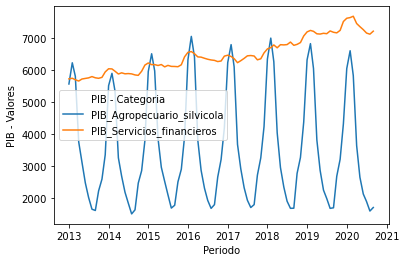

In [223]:
plot_dos_series_historicas_PIB(
    'PIB_Agropecuario_silvicola',
    'PIB_Servicios_financieros',
    fecha_inicio='2013-01-01')

Se observa que el PIB Agropecuario-Silvícola tiene un comportamiento cíclico estacional, teniendo su máximo en comienzos de año (verano) y su mínimo a mediados de año (invierno). En cuanto al PIB de servicios financieros, se oberva un crecimiento sostenido a lo largo del período, con algunos máximos locales que en su mayoría coinciden con los máximos del PIB Agropecuario-Silvícola.

## 4. Tratamiento y creación de variables

__¿Cómo podríamos evaluar la correlación entre las distintas series de tiempo y cómo se tienen que correlacionar  para entrenar un modelo? ¿Mucha correlación, no correlacionadas, da igual?__

Para evaluar la correlación entre las distintas series de tiempo, podemos usar distintas funciones de correlación, como la correlación de Pearson (paramétrica y por defecto en _pandas_, librería usada en este desafío), correlación de Spearman o correlación Tau de Kendall, ambas no paramétricas.

En cuanto a la correlación entre variables, nuestras variables explicativas deben estar correlacionadas positiva o negativamente con nuestra variable objetivo para ser candidatas a la hora de entrenar un modelo. En cambio, idealmente nuestras variables explicativas no deben estar correlacionadas entre si (multicolinealidad), ya que, si bien puede no afectar la capacidad de predicción (en el caso de un modelo predictivo), si afecta en la descripción de la importancia de cada variable explicativa sobre la variable objetivo. A modo de ejemplo: En el caso de crear un modelo de _Random Forest_, dos variables explicativas correlacionadas van a presentar una importancia menor que si sólo se utilizara una sola de ellas.

### Preparando nuestros datos para el entrenamiento del modelo 

Realizamos un _merge_ entre nuestros datos y los datos de precio de la leche (para el productor). Para ello, cargamos los datos de precio de la leche y transformamos la columna de fechas:

In [259]:
# Carga de los datos
precio_leche = pd.read_csv('precio_leche.csv')

# Revisamos los datos
precio_leche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Anio          506 non-null    int64  
 1   Mes           506 non-null    object 
 2   Precio_leche  506 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.0+ KB


In [260]:
# Revisamos las primeras 5 filas
precio_leche.head()

,Anio,Mes,Precio_leche
0,1979,Ene,3.85
1,1979,Feb,4.58
2,1979,Mar,5.18
3,1979,Abr,6.06
4,1979,May,7.25


In [261]:
# Creamos una nueva columna 'Fecha'
def trans_fecha(fila):
    mes_nombre_a_num = {
        'Ene': '01', 'Feb': '02', 'Mar': '03', 'Abr': '04',
        'May': '05', 'Jun': '06', 'Jul': '07', 'Ago': '08',
        'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dic': '12'
    }
    anio = fila['Anio']
    mes = mes_nombre_a_num[fila['Mes']]
    texto_fecha = f"{anio}-{mes}-01"
    return pd.to_datetime(texto_fecha, format='%Y-%m-%d')

precio_leche['Fecha'] = precio_leche.apply(trans_fecha, axis=1)

In [262]:
# Cambiamos la posición de la columna 'Anio'
cols_leche = precio_leche.columns.to_list()
nueva_cols_leche = cols_leche[1:]
nueva_cols_leche.append(cols_leche[0])
precio_leche = precio_leche[nueva_cols_leche]

# Eliminamos la columna 'Mes'
precio_leche = precio_leche.drop('Mes', axis=1)

precio_leche.head()

,Precio_leche,Fecha,Anio
0,3.85,1979-01-01,1979
1,4.58,1979-02-01,1979
2,5.18,1979-03-01,1979
3,6.06,1979-04-01,1979
4,7.25,1979-05-01,1979


In [263]:
# Creamos un nuevo conjunto de datos económicos
# Usaremos sólo las columnas que hemos limpiado
minieconomia = pd.DataFrame()

for col in economia.columns:
    if economia[col].dtype != 'object':
        minieconomia[col] = economia[col]

In [264]:
# Unimos las tablas de datos
Datos_Leche = pd.merge(
    pd.merge(precio_leche, precipitaciones, on='Fecha', how='left'),
    minieconomia, left_on='Fecha', right_on='Periodo', how='left')

# Añadimos nuevas columnas
Datos_Leche['Mes_Numerico'] = Datos_Leche['Fecha'].dt.month
Datos_Leche['Trimestre'] = Datos_Leche['Mes_Numerico'].apply(
    lambda m: np.floor(1 + (m-1)/3))

# Eliminamos columna 'Periodo'
Datos_Leche = Datos_Leche.drop('Periodo', axis=1)

print(Datos_Leche.columns)

Index(['Precio_leche', 'Fecha', 'Anio', 'Coquimbo', 'Valparaiso',
       'Metropolitana_de_Santiago', 'Libertador_Gral__Bernardo_O_Higgins',
       'Maule', 'Biobio', 'La_Araucania', 'Los_Rios',
       'Precio_de_la_onza_troy_de_oro_dolaresoz',
       'Precio_de_la_onza_troy_de_plata_dolaresoz',
       'Precio_del_diesel_centavos_de_dolargalon',
       'Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas',
       'Precio_del_petroleo_Brent_dolaresbarril',
       'Precio_del_petroleo_WTI_dolaresbarril',
       'Precio_del_propano_centavos_de_dolargalon_DTN', 'Ventas_autos_nuevos',
       'Imacec_empalmado', 'Imacec_produccion_de_bienes', 'Imacec_minero',
       'Imacec_industria', 'Imacec_resto_de_bienes', 'Imacec_comercio',
       'Imacec_servicios', 'Imacec_a_costo_de_factores', 'Imacec_no_minero',
       'PIB_Agropecuario_silvicola', 'PIB_Pesca', 'PIB_Mineria',
       'PIB_Mineria_del_cobre', 'PIB_Otras_actividades_mineras',
       'PIB_Industria_Manufacturera', 'PIB

Es razonable pensar que años con mayor variabilidad en las precipitaciones (por ejemplo, un corto período de intensas lluvias y largos períodos secos) también afecte la producción de leche, y por lo tanto, los precios. Además, dado que los efectos de las precipitaciones son acumulativos, cobra sentido considerar las medias y varianzas de las precipitaciones a lo largo de cierto periodo de tiempo:

In [388]:
# Vamos a considerar sólo las precipitaciones para 'Los Ríos', debido a la alta correlación
# entre las precipitaciones de las distintas regiones (Ver más abajo)

# Medias
Datos_Leche['Los Ríos Media Ult. Trimestre'] = Datos_Leche['Los_Rios'].rolling(3).mean()
Datos_Leche['Los Ríos Media Ult. Anio'] = Datos_Leche['Los_Rios'].rolling(12).mean()

# Desviaciones estándares
Datos_Leche['Los Ríos Des. Std. Ult. Trimestre'] = Datos_Leche['Los_Rios'].rolling(3).std()
Datos_Leche['Los Ríos Media Des. Std. Anio'] = Datos_Leche['Los_Rios'].rolling(12).std()

Ahora bien, nosotros queremos predecir el valor futuro de la leche a partir de los datos actuales que tenemos. Luego, el precio de la leche con el que debemos comparar las distintas variables económicas y climáticas son con valores futuros de los precios de la leche. Es por ello que crearemos una columna con los precios futuros de la leche.

In [389]:
Datos_Leche['Precio leche Prox. Mes'] = Datos_Leche['Precio_leche'].shift(1)
Datos_Leche['Precio leche Prox. Trimestre'] = Datos_Leche['Precio_leche'].shift(3)
Datos_Leche['Precio leche Prox. Anio'] = Datos_Leche['Precio_leche'].shift(12)

## 5.- Modelo

Creamos una copia de nuestros datos para nuestro modelo:

In [432]:
Datos_Modelo = Datos_Leche.copy()
Datos_Modelo = Datos_Modelo.drop('Fecha', axis=1)

Podemos observar que algunas varables están muy correlacionadas:

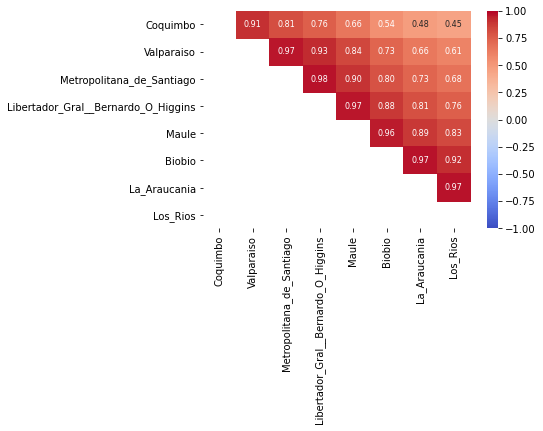

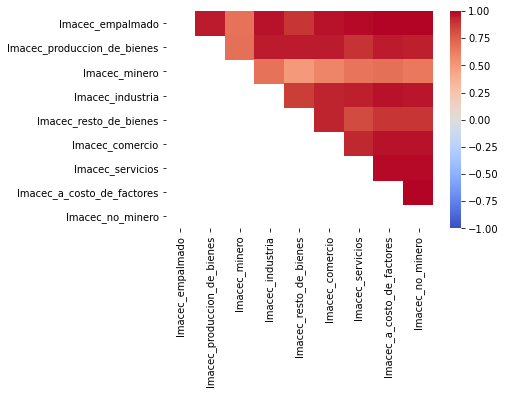

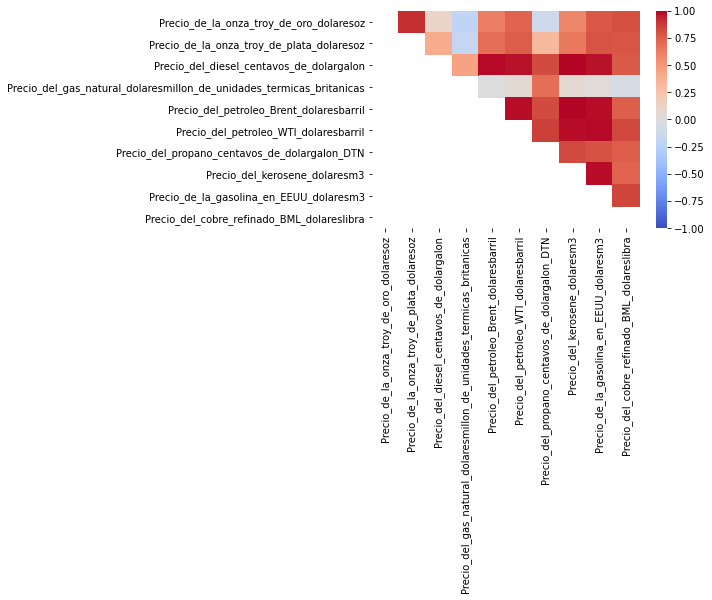

In [433]:
def plot_corr(Data,text=False):
    sns.heatmap(Data.corr(), vmin = -1, vmax = +1, annot = text,
        cmap = 'coolwarm', annot_kws={"fontsize":8}, fmt='.2f', xticklabels=1,
        yticklabels=1, mask=np.tril(Data.corr(),k=0))
    plt.show()

# Datos de PIB
plot_corr(Datos_Leche[cols_region],True)

# Datos de Imacec
plot_corr(Datos_Leche[cols_Imacec])

# Datos de precos de "commodities"
plot_corr(Datos_Leche[cols_precios])


Por lo tanto, las removeremos y sólo nos quedaremos con alguna variable como representativa:

In [434]:
def variables_muy_correlacionadas(Data,maxCorr):
    corr_matrix = Data.corr().abs()
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape),k=0).astype(np.bool))
    return [col for col in upper.columns if any(upper[col] > maxCorr)]

vars_muy_corr_Imacec = variables_muy_correlacionadas(
    Datos_Leche[cols_Imacec],0.9)
vars_muy_corr_Precios = variables_muy_correlacionadas(
    Datos_Leche[cols_precios],0.9)
# Nos quedamos con 'Los Ríos' en vez de 'Coquimbo'
vars_muy_corr_Lluvias = variables_muy_correlacionadas(
    Datos_Leche[cols_region],0.9)
vars_muy_corr_Lluvias.pop()
vars_muy_corr_Lluvias.append('Coquimbo')

# Removemos las variables
Datos_Modelo = Datos_Modelo.drop(vars_muy_corr_Imacec, axis=1)
Datos_Modelo = Datos_Modelo.drop(vars_muy_corr_Precios, axis=1)
Datos_Modelo = Datos_Modelo.drop(vars_muy_corr_Lluvias, axis=1)

In [442]:
# Variables a evaluar
Datos_sin_nan = Datos_Modelo[Datos_Modelo.columns[1:]].dropna()
X = Datos_sin_nan[Datos_sin_nan.columns[:-3]].values
y = Datos_sin_nan[Datos_sin_nan.columns[-3]].values

A continuación, usaremos como algoritmo predictivo una regresión de Lasso, que nos permite realizar una regresión lineal a la vez que descartamos variables sin valor predictivo:

In [443]:
# Estandarizamos (transformamos al "z-score") los valores de las variables predictivas
scaler = StandardScaler()
X_estandarizado = scaler.fit_transform(X)

In [444]:
# Separamos los datos en datos para prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X_estandarizado, y, train_size=0.7)

In [445]:
# Buscamos el mejor modelo
lin_regression = Lasso()
candidatos_alpha = np.logspace(-2,2,20)
espacio_alphas = {'alpha': candidatos_alpha}
gridsearch = GridSearchCV(lin_regression,espacio_alphas, cv=5, verbose=0)
mejor_modelo = gridsearch.fit(X_estandarizado,y)
mejor_modelo.best_estimator_.get_params()['alpha']

/home/mauricio/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.24436500016509, tolerance: 3.043175663428571
  model = cd_fast.enet_coordinate_descent(
/home/mauricio/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.27435213461752, tolerance: 3.3508291857142853
  model = cd_fast.enet_coordinate_descent(
/home/mauricio/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194.15865961105663, tolerance: 3.013112717857142
  model = cd_fast.enet_coordinate_descent(
/home/mauricio/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

0.01

In [446]:
# Realizamos la regresión
regression = Lasso(alpha=0.1)
model = regression.fit(X_train, y_train)

print(model.score(X_test,y_test))

0.8590801135115133


In [449]:
# Revisamos cuales son las variables relevantes y sus coeficientes
coeficientes_validos = (np.abs(model.coef_) > 0)
variables_relevantes = Datos_sin_nan.columns[:-3][coeficientes_validos]
coeficientes = model.coef_[coeficientes_validos]
variables_y_coeficientes=pd.DataFrame({'Variable': variables_relevantes,'Coeficiente':coeficientes})
print(variables_y_coeficientes.sort_values(by='Coeficiente'))

                                        Variable  Coeficiente
18                                PIB_Transporte   -15.095732
3                     PIB_Agropecuario_silvicola    -9.025412
7                                     PIB_Textil    -6.201518
12  PIB_Minerales_no_metalicos_y_metalica_basica    -4.604826
14                              PIB_Electricidad    -4.315920
6                           PIB_Bebidas_y_tabaco    -3.404568
15                              PIB_Construccion    -2.454067
2                            Ventas_autos_nuevos    -1.431949
19                            PIB_Comunicaciones    -1.284512
9                                   PIB_Celulosa    -0.808869
21                                     Trimestre    -0.525963
11                                   PIB_Quimica     0.032518
24             Los Ríos Des. Std. Ult. Trimestre     0.594184
1                                       Los_Rios     1.286083
22                 Los Ríos Media Ult. Trimestre     1.466193
13      

Lamentablemente nuestro modelo arroja demasiadas variables como predictores y no todas parecen ser relevantes, como por ejemplo, el PIB de otras actividades mineras.